# AdaptiveMasterMSM-Analyzer: Create new inputs
The aim of this notebook is to determine which method is best in order to create new inputs without bias according to the results previously obtained employing some scoring function or criteria.

In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import mdtraj as md

In [3]:
from adaptivemastermsm.analyzer import analyzer

First we load the data onto analyzer

In [4]:
an = analyzer.Analyzer('data/protein_only.xtc', )

['data/protein_only.xtc']


Analyzer takes care of clustering and discretizing and building the MSM. It's all contained in the `build_msm` function.

In [7]:
# n_runs, lag time
an.build_msm(10, 10, mcs=50, ms=58, sym=False, gro='data/alaTB.gro', \
             rate_mat=False)


 Building MSM from 
 ['data/protein_only.xtc']
     # states: 5
MSM done


Then, according to some criterion, we choose initial states for the next epoch.

In [8]:
states = an.populs()
print (states)

[0.53553032 0.40478313 0.04585839 0.00753403 0.00629413]


In [10]:
# Determine distribution of new runs according to 'states', that is,
# inverse of MSM equilibrium populations
n_runs = 10
n_msm_runs = np.random.choice(range(5), 10, p=states)
print (n_msm_runs)

[1 1 1 0 0 0 1 0 2 0]


#### New implementation with dictionary of frame selection

In [8]:
an.trajs[0].distraj, an.trajs[0].dt

(array([4, 4, 4, ..., 3, 3, 3]), 1.0)

In [12]:
def gen_dict_state(s, an):
    """
    Generates dictionary entry for state s
    
    Parameters
    ----------
    s : str, int
        The key for the state
    an : object
        The Analyzer object istance that contains everything
    
    """
    global state_kv
    state_kv[s] = []
    for t in an.trajs:
        try:
            ivals = np.where(t.distraj == s)[0]
            for i in ivals:
                state_kv[s].append([t.mdt, i])
        except KeyError:
            pass

In [13]:
state_kv = {}
for n in n_msm_runs:
    if n not in state_kv.keys():
        print ("Building entry for microstate %g"%n)
        gen_dict_state(n, an)
    traj, frame = random.choice(state_kv[n])
    print (n, traj, frame)

Building entry for microstate 1
1 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 4315
1 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 4336
1 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 4321
Building entry for microstate 0
0 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 5226
0 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 9652
0 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 3129
1 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 4311
0 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 522
Building entry for microstate 2
2 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 6258
0 <mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells> 7962


In [ ]:
#from adaptivemastermsm.analyzer import analyzer_lib
#analyzer_lib.gen_input_weights(n_msm_runs, an.labels_all, an.trajs)

#### CHECKS!

Now let's see how this works step by step.

The first thing we do is to load the trajectory or trajectories and discretize them using built in procedures in `MasterMSM`. In this particular example, we are just using Ramachandran angles. We will do this manually here to check whether it is working sensibly.

In [23]:
i, phi = md.compute_phi(an.trajs[0].mdt)
i, psi = md.compute_psi(an.trajs[0].mdt)

In the plot below we show the Ramachandran angles colour-coded by cluster number, corresponding to the labels within the `Analyzer` object.

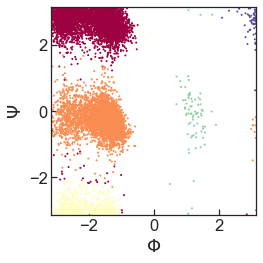

In [24]:
plt.figure(figsize=(4,4))
plt.scatter(phi, psi, marker='o', s=1, c=an.labels_all[0], \
            cmap='Spectral_r')
plt.xlabel('$\Phi$')
plt.ylabel('$\Psi$')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.tight_layout()

A few datapoints seem to be off. Is this what you'd get from clustering via HDBSCAN?

In [25]:
import hdbscan
clusterer = hdbscan.HDBSCAN()
clusterer.fit(np.hstack([phi, psi]))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

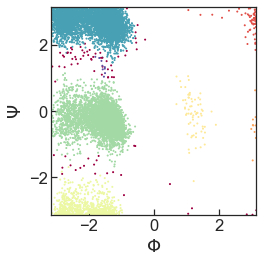

In [26]:
plt.figure(figsize=(4,4))
plt.scatter(phi, psi, marker='o', s=1, c=clusterer.labels_, \
            cmap='Spectral')
plt.xlabel('$\Phi$')
plt.ylabel('$\Psi$')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.tight_layout()

Clearly, there seems to be something funny going on here. Some datapoints that a rough, parameter-free call to HDBSCAN leaves out, are assigned in the discrete trajectory. Part of it may be due to TBA, but there are some rather non-intuitive cases in the regions between the $\alpha$ and $\beta$ regions of the Ramachandran map.

Then comes the MSM generation, which is invoked by the `gen_msm` method within the `Analyzer` class, resulting in the following:

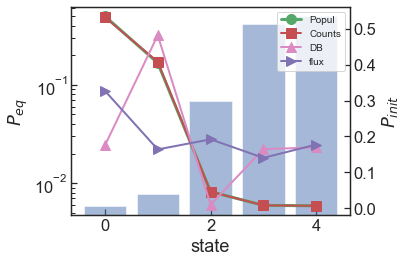

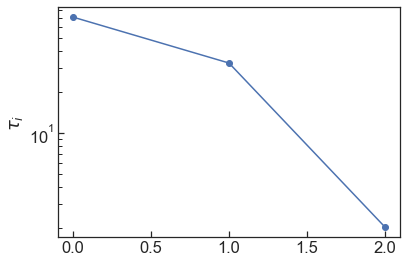

In [27]:
fig, ax = plt.subplots()
ax.bar(an.MSM.keep_keys, an.MSM.peqT, alpha=0.5)
ax.set_yscale('log')
ax.set_ylabel('$P_{eq}$')
axt = ax.twinx()
axt.plot(an.MSM.keep_keys, an.populs(), 'o-', c='C2',\
         lw=3, ms=10, label='Popul')
axt.plot(an.MSM.keep_keys, an.counts(), 's-', c='C3',\
         lw=2, ms=10, label='Counts')
axt.plot(an.MSM.keep_keys, an.non_detbal(), '^-', \
         c='C6', lw=2, ms=10, label='DB')
axt.plot(an.MSM.keep_keys, an.flux_inbalance(), '>-', \
         c='C4', lw=2, ms=10, label='flux')
axt.set_ylabel('$P_{init}$')
ax.set_xlabel('state')
plt.legend(fontsize=10)
plt.tight_layout()

fig, ax = plt.subplots()
ax.plot(range(len(an.MSM.keep_keys)-1), an.MSM.tauT, 'o-')
ax.set_yscale('log')
ax.set_ylabel(r'$\tau_i$')
plt.tight_layout()

In [28]:
an.MSM.tauT

[70.70072209594991, 32.59024495630128, 2.0510889369832217, nan]